In [43]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
import operator
import numpy as np

In [37]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
def plot_sign_aspect_ratio(df):
    sns.distplot(df.SignAspectRatio)
    plt.show()

In [4]:
def plot_angle(df):
    sns.distplot(df.AngleOfSign)
    plt.show()

In [5]:
def plot_height(df):
    sns.distplot(df.SignHeight)
    plt.show()

In [112]:
# #encode as integer
# mapping = {'Front':0, 'Right':1, 'Left':2, 'Rear':3}
# train = train.replace({'DetectedCamera':mapping})
# test = test.replace({'DetectedCamera':mapping})

In [38]:
train.rename(columns = {'SignFacing (Target)': 'Target'}, inplace=True)

In [39]:
#encode Target Variable based on sample submission file
mapping = {'Front':0, 'Left':1, 'Rear':2, 'Right':3}
train = train.replace({'Target':mapping})

In [32]:
trunc_id_dict = {}

def trunc_id_map(row):

    trunc_id = str(row["Id"])[:-1]
    
    if trunc_id not in trunc_id_dict:
        trunc_id_dict[trunc_id] = 1
    else:
        trunc_id_dict[trunc_id] += 1
        
train.apply(trunc_id_map, axis = 1)
test.apply(trunc_id_map, axis = 1)

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
         ... 
31455    None
31456    None
31457    None
31458    None
31459    None
31460    None
31461    None
31462    None
31463    None
31464    None
31465    None
31466    None
31467    None
31468    None
31469    None
31470    None
31471    None
31472    None
31473    None
31474    None
31475    None
31476    None
31477    None
31478    None
31479    None
31480    None
31481    None
31482    None
31483    None
31484    None
dtype: object

In [40]:
train = pd.concat([train, pd.get_dummies(train.DetectedCamera)], axis = 1)
test = pd.concat([test, pd.get_dummies(test.DetectedCamera)], axis = 1)

In [41]:
def get_features(row):
    
    diag_length = pow(pow(row.SignWidth, 2) + pow(row.SignHeight, 2), 0.5)
    
    front = row["Front"]*row["AngleOfSign"]
    right = row["Right"]*(row["AngleOfSign"]-50)
    rear = row["Rear"]*(row["AngleOfSign"]-180)
    left = row["Left"]*(row["AngleOfSign"]-220)
    
    return pd.Series({
        "diag_length": diag_length,
        "front": front,
        "right": right,
        "rear": rear,
        "left": left
    })

train = pd.concat([train, train.apply(get_features, axis = 1)], axis = 1)
test = pd.concat([test, test.apply(get_features, axis = 1)], axis = 1)

In [49]:
# front_front = np.mean(train[(train.DetectedCamera == "Front") & (train.Target == 0)].AngleOfSign)
front_left = np.mean(train[(train.DetectedCamera == "Front") & (train.Target == 1)].AngleOfSign)
front_rear = np.mean(train[(train.DetectedCamera == "Front") & (train.Target == 2)].AngleOfSign)
front_right = np.mean(train[(train.DetectedCamera == "Front") & (train.Target == 3)].AngleOfSign)

left_front = np.mean(train[(train.DetectedCamera == "Left") & (train.Target == 0)].AngleOfSign)
left_left = np.mean(train[(train.DetectedCamera == "Left") & (train.Target == 1)].AngleOfSign)
left_rear = np.mean(train[(train.DetectedCamera == "Left") & (train.Target == 2)].AngleOfSign)
left_right = np.mean(train[(train.DetectedCamera == "Left") & (train.Target == 3)].AngleOfSign)

rear_front = np.mean(train[(train.DetectedCamera == "Rear") & (train.Target == 0)].AngleOfSign)
rear_left = np.mean(train[(train.DetectedCamera == "Rear") & (train.Target == 1)].AngleOfSign)
rear_rear = np.mean(train[(train.DetectedCamera == "Rear") & (train.Target == 2)].AngleOfSign)
rear_right = np.mean(train[(train.DetectedCamera == "Rear") & (train.Target == 3)].AngleOfSign)

right_front = np.mean(train[(train.DetectedCamera == "Right") & (train.Target == 0)].AngleOfSign)
right_left = np.mean(train[(train.DetectedCamera == "Right") & (train.Target == 1)].AngleOfSign)
right_rear = np.mean(train[(train.DetectedCamera == "Right") & (train.Target == 2)].AngleOfSign)
right_right = np.mean(train[(train.DetectedCamera == "Right") & (train.Target == 3)].AngleOfSign)

def get_collective_feats(row):
    
    if row["DetectedCamera"] == "Front":
        diff_from_front = row["AngleOfSign"] - front_front
        diff_from_left = row["AngleOfSign"] - front_left        
        diff_from_rear = row["AngleOfSign"] - front_rear        
        diff_from_right = row["AngleOfSign"] - front_right       
        
    elif row["DetectedCamera"] == "Left":
        diff_from_front = row["AngleOfSign"] - left_front
        diff_from_left = row["AngleOfSign"] - left_left        
        diff_from_rear = row["AngleOfSign"] - left_rear        
        diff_from_right = row["AngleOfSign"] - left_right

    elif row["DetectedCamera"] == "Rear":
        diff_from_front = row["AngleOfSign"] - rear_front
        diff_from_left = row["AngleOfSign"] - rear_left        
        diff_from_rear = row["AngleOfSign"] - rear_rear        
        diff_from_right = row["AngleOfSign"] - rear_right        
        
    elif row["DetectedCamera"] == "Right":
        diff_from_front = row["AngleOfSign"] - right_front
        diff_from_left = row["AngleOfSign"] - right_left        
        diff_from_rear = row["AngleOfSign"] - right_rear        
        diff_from_right = row["AngleOfSign"] - right_right        
        
    return pd.Series({
        "diff_from_front": diff_from_front,
        "diff_from_left": diff_from_left,
        "diff_from_rear": diff_from_rear,
        "diff_from_right": diff_from_right
    })

#Introducing a slight model leakage for validation!
train = pd.concat([train, train.apply(get_collective_feats, axis = 1)], axis = 1)
test = pd.concat([test, test.apply(get_collective_feats, axis = 1)], axis = 1)

In [51]:
def get_trunc_similar(row):
    
    return trunc_id_dict[str(row["Id"])[:-1]]

train["trunc_num"] = train.apply(get_trunc_similar, axis = 1)
test["trunc_num"] = test.apply(get_trunc_similar, axis = 1)

In [52]:
#Clean label columns
label = train.pop("Target")
test_ids = test.pop("Id")

#drop columns
train.drop(['Id', 'DetectedCamera'], inplace=True, axis=1)
test.drop(['DetectedCamera'], inplace=True,axis=1)

#Validation split
x_train, x_valid, label_train, label_valid = train_test_split(train, label, test_size=0.2, random_state=4242, stratify = label)

In [96]:
# #train model
# clf = RandomForestClassifier(n_estimators=500,max_features=3,min_samples_split=5,oob_score=True)
# clf.fit(x_train, label_train)

# #predict on test data
# pred = clf.predict_proba(x_valid)
# print 100 - metrics.log_loss(label_valid, pred)

99.8535907724


In [97]:
# print zip(x_train.columns, clf.feature_importances_)

[('DetectedCamera', 0.44894817484772487), ('AngleOfSign', 0.41385682022369252), ('SignAspectRatio', 0.023462150230924763), ('SignWidth', 0.017843411293481982), ('SignHeight', 0.038289898624377337), ('diag_length', 0.049989477718260594), ('trunc_num', 0.007610067061537649)]


In [58]:
def run_xgb(x_train, label_train, x_valid = None, label_valid = None):

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss'
    params['eta'] = 0.02
    params['num_class'] = 4
    params['max_depth'] = 4
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 13

    d_train = xgb.DMatrix(x_train, label=label_train)
    
    if x_valid is not None:
        d_valid = xgb.DMatrix(x_valid, label=label_valid)
        watchlist = [(d_train, 'train'), (d_valid, 'validation')]
    else:
        watchlist = [(d_train, 'train')]
        
    bst = xgb.train(params, d_train, 550, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

In [57]:
#Validation Run
bst = run_xgb(x_train, label_train, x_valid, label_valid)

importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

df_imp

[0]	train-mlogloss:1.34978	validation-mlogloss:1.34976
Multiple eval metrics have been passed: 'validation-mlogloss' will be used for early stopping.

Will train until validation-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:0.476306	validation-mlogloss:0.476808
[100]	train-mlogloss:0.229137	validation-mlogloss:0.230975
[150]	train-mlogloss:0.143662	validation-mlogloss:0.147577
[200]	train-mlogloss:0.111902	validation-mlogloss:0.118329
[250]	train-mlogloss:0.099112	validation-mlogloss:0.108067
[300]	train-mlogloss:0.093291	validation-mlogloss:0.104515
[350]	train-mlogloss:0.090185	validation-mlogloss:0.103167
[400]	train-mlogloss:0.087942	validation-mlogloss:0.102501
[450]	train-mlogloss:0.08607	validation-mlogloss:0.102174
[500]	train-mlogloss:0.084195	validation-mlogloss:0.101931
[550]	train-mlogloss:0.082347	validation-mlogloss:0.101868
[600]	train-mlogloss:0.080594	validation-mlogloss:0.10192
Stopping. Best iteration:
[558]	train-mlogloss:0.082067	validation-mlogloss:0

,feature,fscore
0,Left,0.001258
1,Front,0.001598
2,Right,0.003569
3,Rear,0.005031
4,front,0.012135
5,rear,0.019886
6,left,0.027160
7,right,0.030356
8,diff_from_left,0.033211
9,diff_from_right,0.041267


In [59]:
# Real Test Run + Submit
bst = run_xgb(train, label)

d_test = xgb.DMatrix(test)
p_test = bst.predict(d_test)

columns = ['Front','Left','Rear','Right']
sub = pd.DataFrame(data=p_test, columns=columns)
sub['Id'] = test_ids
sub = sub[['Id','Front','Left','Rear','Right']]
sub.to_csv("./subs/xgb_2.csv", index=False)

[0]	train-mlogloss:1.34956
Will train until train-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:0.475977
[100]	train-mlogloss:0.229009
[150]	train-mlogloss:0.144007
[200]	train-mlogloss:0.112694
[250]	train-mlogloss:0.10018
[300]	train-mlogloss:0.094753
[350]	train-mlogloss:0.091891
[400]	train-mlogloss:0.089879
[450]	train-mlogloss:0.088187
[500]	train-mlogloss:0.08651
[549]	train-mlogloss:0.084889


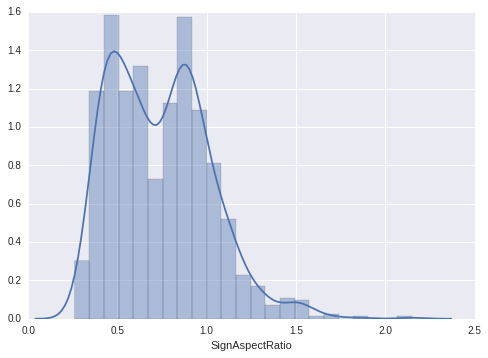

In [68]:
plot_sign_aspect_ratio(train[(train.DetectedCamera == "Left") & (train.Target == "Front")])

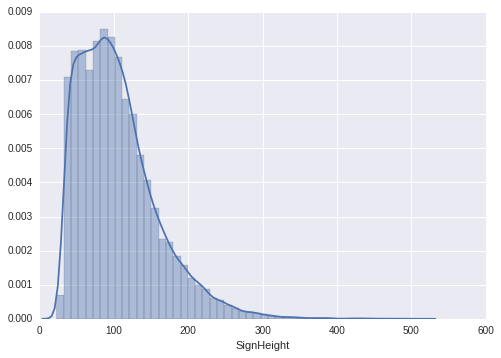

In [100]:
plot_height(train)

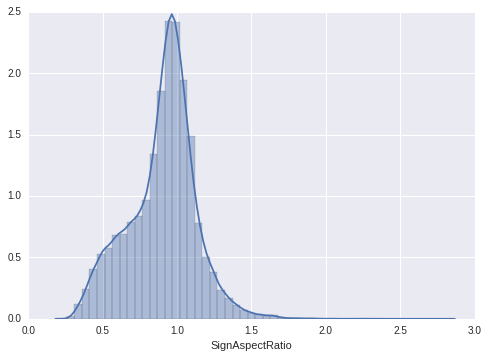

In [31]:
plot_sign_aspect_ratio(train)

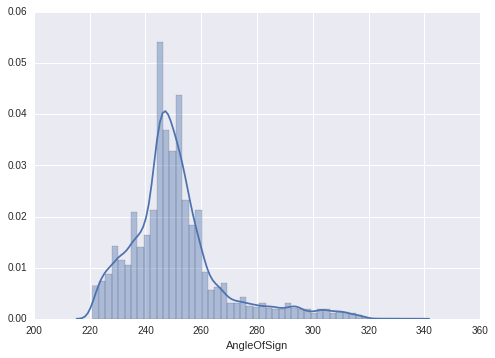

In [153]:
plot_angle(train[train.DetectedCamera == "Left"])

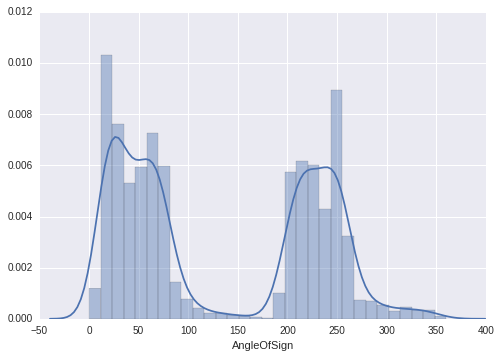

In [58]:
plot_angle(test)

In [141]:
train.head()

,Id,DetectedCamera,AngleOfSign,SignAspectRatio,SignWidth,SignHeight,SignFacing (Target)
0,2c9180975a056a64015a1e0a52e57021,Rear,195,1.02,46,45,Rear
1,2c9180975a056a64015a1e17b32171e4,Rear,203,1.09,59,54,Rear
2,2c9180975a056a64015a1de4deb16bd5,Front,26,0.96,104,108,Front
3,2c9180975a056a64015a1de4deb16bdd,Rear,199,0.81,38,47,Rear
4,2c9180975a056a64015a1de4deb16bd6,Rear,208,0.93,54,58,Rear
